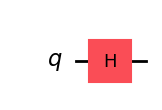

In [1]:
from qiskit import QuantumCircuit

# 2 qubits = 4 hidden states
initial_state = QuantumCircuit(1, name='Initial_State')
initial_state.h(0)
#initial_state.cx(0,1)
initial_state.draw('mpl')

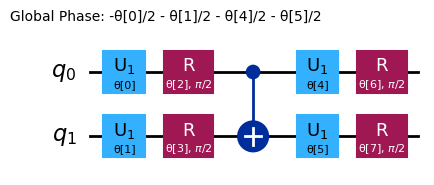

In [2]:
from qiskit.circuit.library import real_amplitudes, efficient_su2

#ansatz = real_amplitudes(3, reps=1)
ansatz = efficient_su2(2, reps=1, entanglement='pairwise', su2_gates=['rz','ry'])
ansatz.decompose(reps=1).draw('mpl')

In [3]:
import numpy as np

# Generating and starting parameters
num_parameters = ansatz.num_parameters

#theta_gen = [np.random.uniform(2*np.pi,  6* np.pi) for _ in range(num_parameters)]
#theta_0 = [4*np.pi for _ in range(num_parameters)]

theta_gen = [np.random.uniform(-2*np.pi,  2*np.pi) for _ in range(num_parameters)]
theta_0 = [0 for _ in range(num_parameters)]

In [4]:
# Training Hyperparameters
sequence_length = 4
tol = 1e-6
max_iter = 100

In [5]:
from HMM.utils.qhmm_utils import result_getter
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
import itertools

class custom_result_getter(result_getter):
    def _cost(self,
              target_dist : dict,
              current_dist : dict):
        cost = 0
        # calculate the total number of counts/ probability to normalize the distributions
        total_current = sum(current_dist.values())
        total_target = sum(target_dist.values())

        # for sequence in either group of keys
        for sequence in set(target_dist.keys()).union(current_dist.keys()):

            # Normalize the probability of the sequence. If it does not exist set it to 0
            pt = target_dist.get(sequence,0)/total_target
            pc = current_dist.get(sequence, 0)/total_current

            # add the squared error of the cost
            cost += len(sequence)*((pt - pc)**2)
        return cost

    def generate_sequence(self, circuit):
        super().generate_sequence()
        backend = AerSimulator()
        transpiled = transpile(circuit, backend)
        sampler = Sampler(mode=backend)
        job = sampler.run([transpiled], shots=10000)
        results = job.result()[0].data
        digits = [str(i) for i in range(2**len(circuit.qregs[1]))]
        length = len(circuit.cregs)
        sequences = {"".join(key) : 0 for key in itertools.product(digits, repeat=length)}
        for shot in range(1000):
            sequence = []
            for key in results.keys():
                sequence.append(str(int(results[key].array[shot, 0])))
            sequences["".join(sequence)] += 1
        return sequences
    
    def log_likelihood(self, circuit, sequence):
        total_target = sequence
        total_current = self.generate_sequence(circuit)
        cost = self._cost(total_target, total_current)
        return -cost

custom_rg = custom_result_getter()

In [6]:
from HMM import QHMM

generating_model = QHMM(result_getter=custom_rg,
                        initial_state=initial_state,
                        ansatz=ansatz,
                        theta=theta_gen)

training_model_simulator = QHMM(result_getter=custom_rg,
                                initial_state=initial_state,
                                ansatz=ansatz)

In [7]:
sequence = generating_model.generate_sequence(sequence_length)

In [8]:
from HMM.utils.qhmm_utils import minimize_qhmm

theta_trained, training_time, training_curve = minimize_qhmm(model = training_model_simulator,
              sequence=sequence,
              theta_0=theta_0,
              max_iter=max_iter,
              tol=tol)


In [9]:
print(training_curve[-1])
'0.0019520000000000008'

0.033151999999999994


'0.0019520000000000008'

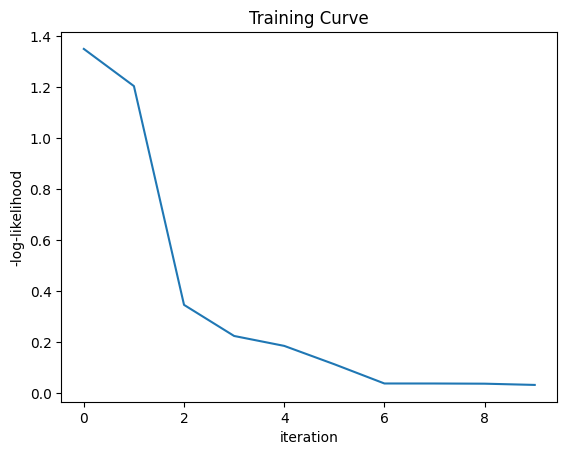

In [10]:
import matplotlib.pyplot as plt

plt.plot(training_curve)
plt.xlabel('iteration')
plt.ylabel('-log-likelihood')
plt.title('Training Curve')
plt.show()

In [11]:
theta_gen

[3.974812034051075,
 -1.5847196576020544,
 4.716362171515353,
 -4.126528103208183,
 3.1820954826058507,
 0.009676801644443955,
 -4.070933802428128,
 -4.333844974474113]

In [12]:
theta_trained

[-0.5463849331659405,
 -0.08571509669744973,
 -0.2940732227281668,
 1.2182201344303083,
 0.2884578047938683,
 -0.5415581895681476,
 -0.07916877209303756,
 1.2879604003198868]

In [13]:
final_hist = training_model_simulator.generate_sequence(length=sequence_length)

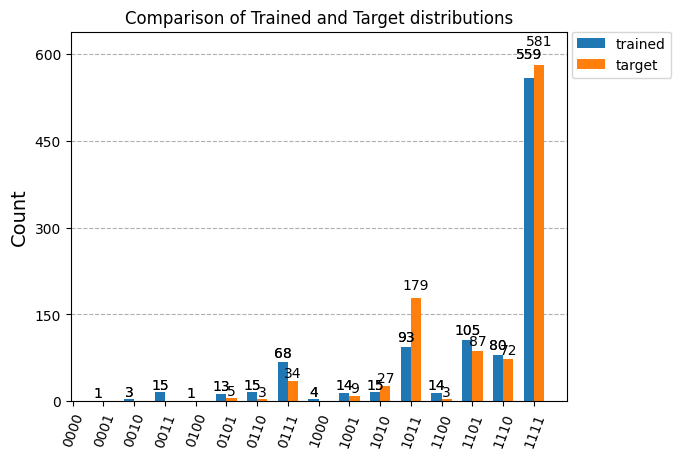

In [14]:
from qiskit.visualization import plot_histogram

plot_histogram([final_hist, sequence],
               legend=['trained', 'target'],
               title='Comparison of Trained and Target distributions',
               )